This notebook contains a toy example to illustrate the difference between common approaches to uncertainty estimation and evidential deep learning. We do this for both classification and regression using the Iris dataset for classification and a synthetic dataset for regression.

## Classification Example

In [1]:
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import lgamma
import torch.special as special
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tqdm import tqdm

In [14]:
# Load dataset
iris_dataset = datasets.load_iris()

# Only retain the first two features per point - sepal length and sepal width
X = iris_dataset.data[:, :2] 
y = iris_dataset.target

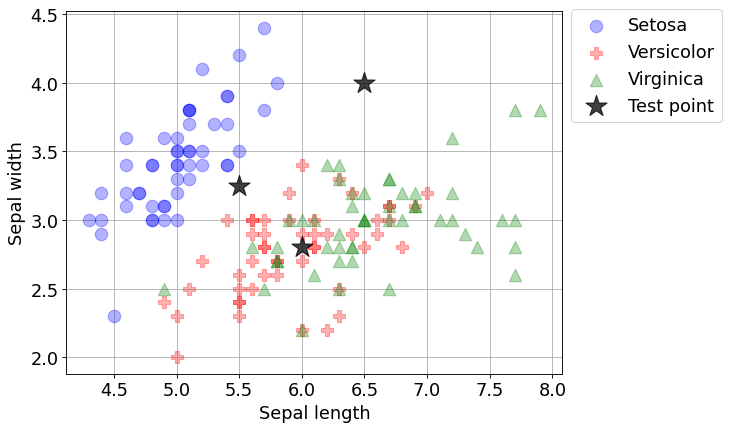

In [3]:
# Plot the dataset!
plt.figure(figsize=(8, 6), dpi=80)
plt.grid(visible=True)
ax = plt.gca()

for label, (marker, color, name) in enumerate(
        zip(["o", "P", "^"], ["blue", "red", "green"], iris_dataset.target_names)
    ):
    
    selector = (y == label)
    plt.scatter(
        X[selector, 0], X[selector, 1], 
        marker=marker, color=color, alpha=0.3, s=125, 
        label=name[0].upper() + name[1:]
    )
    
# Define test points that will be used later
TEST_POINT1 = [6, 2.8]
TEST_POINT2 = [5.5, 3.25]
TEST_POINT3 = [6.5, 4]

for i, (x, y) in zip(
    range(3), 
    [TEST_POINT1, TEST_POINT2, TEST_POINT3]
):
    label = "Test point" if i == 0 else None
    plt.scatter(x, y, color="black", marker="*", label=label, s=400, alpha=0.75)
   
ax.set_axisbelow(True)
ax.set_xlabel("Sepal length", fontsize = 16)
ax.set_ylabel('Sepal width', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.85))
plt.show()

Now we define the models we are going to test: An ensemble, Monte Carlo Dropout, and a prior network.

In [4]:
class Model:
    
    def train(self, data: torch.utils.data.DataLoader, num_epochs: int):
        
        with tqdm(total=len(data) * num_epochs) as progress_bar:
            for epoch in range(num_epochs):

                for i, (x, y) in enumerate(data):

                    loss = self.get_loss(x, y)
                    loss.backward()

                    self.optimizer.step()
                    self.optimizer.zero_grad()  
                    
                    progress_bar.set_description(
                        f"[Epoch {epoch+1}/{num_epochs} | Batch {i+1}/{len(data)}]: Loss {loss.detach().numpy():.3f}"
                    )
                    progress_bar.update(1)
                    

class MultiPredictionModel(Model):
    
    def predict(self, x: torch.FloatTensor):
        
        preds = self.get_predictions(x)
        preds = preds.mean()
        
        return preds
    

class ClassificationEnsemble(MultiPredictionModel):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, output_size: int, num_members: int, 
        learning_rate: float = 0.001, dropout: float = 0.
    ):
        super().__init__()
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.models = nn.ModuleList([
            nn.Sequential(
                *modules,
                nn.Linear(sizes[-1], output_size)
            ) for _ in range(num_members)
        ])
        
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            params=self.models.parameters(),
            lr=learning_rate
        )
    
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        loss = 0
        
        for model in self.models:
            loss += self.loss_function(model(x), y)
            
        return loss
    
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = []
        
        for model in self.models:
            pred = F.softmax(model(x), dim=-1)
            preds.append(pred)
            
        preds = torch.stack(preds)
        
        return preds

    
class ClassificationMCDropout(MultiPredictionModel):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, output_size: int, num_predictions: int, 
        learning_rate: float = 0.001, dropout: float = 0.1
    ):
        super().__init__()
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        self.num_predictions = num_predictions
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.model = nn.Sequential(
            *modules,
            nn.Linear(sizes[-1], output_size)
        )
        
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=learning_rate
        )
        
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = []
        self.model.train()
        
        for _ in range(self.num_predictions):
            pred = F.softmax(self.model(x), dim=-1)
            preds.append(pred)
            
        preds = torch.stack(preds)
        
        return preds
    
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        loss = 0
        self.model.train()
        
        for _ in range(self.num_predictions):
            loss += self.loss_function(self.model(x), y)
            
        return loss
    

In [162]:
class ClassificationPriorNetwork(Model):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, output_size: int,  
        learning_rate: float = 0.001, dropout: float = 0.1, regularization_factor: float = 0.1
    ):
        super().__init__()
        self.output_size = output_size
        self.regularization_factor = regularization_factor
        
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.model = nn.Sequential(
            *modules,
            nn.Linear(sizes[-1], output_size),
        )
        
        self.loss_function = lambda pred, target: torch.sum((target - pred) ** 2, dim=-1).mean()
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=learning_rate
        )
        
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        import math
        log_gamma_approx = lambda arg: 0.5 * math.log(2 * math.pi) - arg + (arg - 0.5) * torch.log(arg)
        digamma_approx = lambda arg: torch.log(arg) - 1 / (2 * arg)
        
        loss = 0
        alphas = self.model(x)
        alphas = 1 + torch.relu(alphas)
        
        #print("Alphas", alphas.shape, alphas)
        
        preds = alphas / alphas.sum(dim=-1, keepdim=True)
        #print(preds.shape, preds)
        
        y = torch.nn.functional.one_hot(y, num_classes=self.output_size)
        loss += self.loss_function(preds, y)
        #print(loss)
        #print("Out", self.output_size)
        reg_term = log_gamma_approx(torch.FloatTensor([self.output_size])) - log_gamma_approx(alphas.sum(dim=-1, keepdim=True)) + log_gamma_approx(alphas).sum(dim=-1, keepdim=True)
        
        #print("Debug1", log_gamma_approx(torch.FloatTensor([self.output_size])))
        #print("Debug2", log_gamma_approx(alphas.sum(dim=-1, keepdim=True)))
        #print("Debug3", log_gamma_approx(alphas).sum(dim=-1, keepdim=True))
        #print("Debug", digamma_approx(torch.FloatTensor(self.output_size)), digamma_approx(alphas.sum(dim=-1, keepdim=True)), torch.lgamma(alphas), torch.lgamma(alphas).sum(dim=-1, keepdim=True))
        #print("Reg", reg_term.shape, reg_term)
        
        reg_term += torch.sum((alphas - 1) * (digamma_approx(alphas) - digamma_approx(alphas.sum(dim=-1, keepdim=True))), dim=-1, keepdim=True)
        
        
        #print("Reg2", reg_term.shape, reg_term)
        #print("Loss", loss.shape)
            
        
        loss -= self.regularization_factor * reg_term.squeeze().sum()
        
        
        return loss
    
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = self.model(x)
        preds = 1 + torch.exp(preds)
        preds /= preds.sum(dim=-1)
        
        return preds
    
    def get_alphas(self, x: torch.FloatTensor):
        
        alphas = self.model(x)
        alphas = 1 + torch.exp(alphas)
        
        return alphas
        

In [170]:
INPUT_SIZE = 2
HIDDEN_SIZE = 20
NUM_LAYERS = 2
OUTPUT_SIZE = 3
LEARNING_RATE = 0.00001
NUM_MEMBERS = 50
NUM_PREDICTIONS = 50
BATCH_SIZE = 16
NUM_EPOCHS = 20
REGULARIZATION_FACTOR = 0.01

In [36]:
classification_ensemble = ClassificationEnsemble(
    input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, 
    output_size=OUTPUT_SIZE, num_members=NUM_MEMBERS, learning_rate=LEARNING_RATE
)

In [37]:
classification_mcdropout = ClassificationMCDropout(
    input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, 
    output_size=OUTPUT_SIZE, num_predictions=NUM_PREDICTIONS, learning_rate=LEARNING_RATE
)

In [171]:
classification_priornet = ClassificationPriorNetwork(
    input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, 
    output_size=OUTPUT_SIZE, learning_rate=LEARNING_RATE, regularization_factor=REGULARIZATION_FACTOR
)

In [39]:
# Create dataloader 
split_iris_data = list(zip(
    [x.squeeze() for x in torch.FloatTensor(X).squeeze().split(1)], 
    [y.squeeze() for y in torch.LongTensor(y).squeeze().split(1)]
))

iris_data_loader = torch.utils.data.DataLoader(
    split_iris_data, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [40]:
#print(classification_ensemble.optimizer.param_groups)
classification_ensemble.train(iris_data_loader, num_epochs=NUM_EPOCHS)

[Epoch 20/20 | Batch 10/10]: Loss 27.880: 100%|████████████████████████████████████| 200/200 [00:02<00:00, 70.16it/s]


In [41]:
classification_mcdropout.train(iris_data_loader, num_epochs=NUM_EPOCHS)

[Epoch 20/20 | Batch 10/10]: Loss 34.771: 100%|████████████████████████████████████| 200/200 [00:02<00:00, 78.30it/s]


In [172]:
classification_priornet.train(iris_data_loader, num_epochs=NUM_EPOCHS)

[Epoch 20/20 | Batch 10/10]: Loss 0.718: 100%|████████████████████████████████████| 200/200 [00:00<00:00, 449.04it/s]


In [160]:
# The following code was taken from https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)


def plot_predictions(preds: torch.FloatTensor, subdiv=8, nlevels=20):
    preds = preds.detach().numpy()
    
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    
    ccorners = list(corners)
    
    # Draw corners
    for corner_a, corner_b in zip(ccorners + ccorners[:1], ccorners[1:] + ccorners[:2]):
        plt.plot([corner_a[0], corner_b[0]], [corner_a[1], corner_b[1]], color="black", linewidth=2)

    #triang = tri.Triangulation(np.arange(0, 1, 100), np.arange(0, 1, 100),  preds.detach().numpy())
    
    #pvals = [0 for xy in zip(trimesh.x, trimesh.y)]
    #print("Triang", triang)
    
    #plt.tricontourf(trimesh, pvals, nlevels, cmap='gray')
    def get_cartesian_from_barycentric(b, t):
        return t.T @ b

    cart_coords = [
        get_cartesian_from_barycentric(pred, corners) for pred in preds
    ]
    
    for x, y in cart_coords:
        plt.scatter(x, y, marker="x", s=50, color="blue", alpha=0.8)

    #plt.tricontourf(trimesh, pvals, nlevels, cmap='viridis', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        
        def safe_gamma(arg):
            try:
                return gamma(arg)
            
            except OverflowError:
                return 0.5 * math.log(2 * math.pi) - arg + (arg - 0.5) * math.log(arg)
        
        self._alpha = np.array(alpha)
        self._coef = safe_gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([safe_gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(alphas, nlevels=200, subdiv=8, **kwargs):
    
    dist = Dirichlet(alphas)
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='viridis', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()

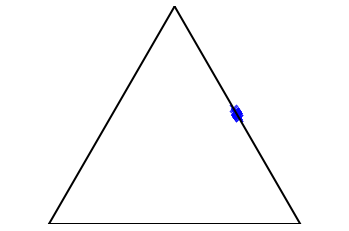

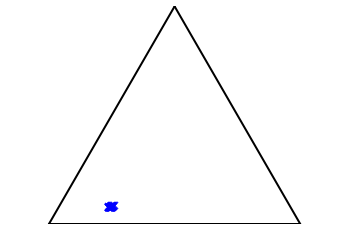

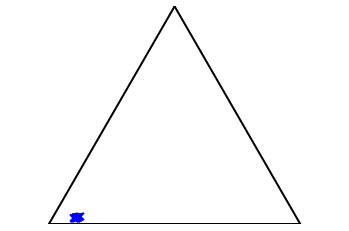

In [102]:
for point in [TEST_POINT1, TEST_POINT2, TEST_POINT3]:
    preds_ensemble = classification_ensemble.get_predictions(torch.FloatTensor(point))
    #print(preds_ensemble.shape, preds_ensemble)
    plot_predictions(preds_ensemble)

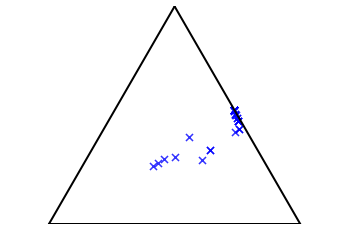

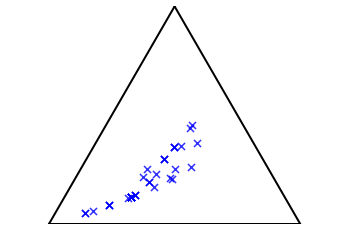

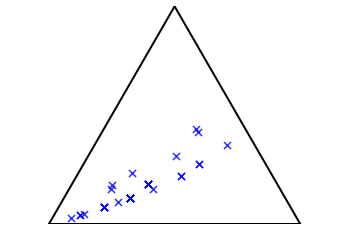

In [103]:
for point in [TEST_POINT1, TEST_POINT2, TEST_POINT3]:
    preds_mcdropout = classification_mcdropout.get_predictions(torch.FloatTensor(point))
    #print(preds_mcdropout.shape, preds_mcdropout)
    plot_predictions(preds_mcdropout)

tensor([0.4191, 0.2452, 0.3357], grad_fn=<DivBackward0>)
tensor([2.3582, 1.4666, 2.5059], grad_fn=<AddBackward0>)


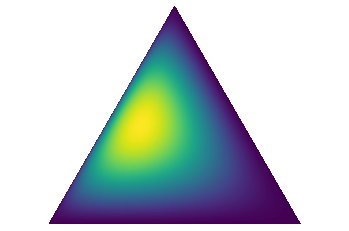

tensor([0.4351, 0.2359, 0.3289], grad_fn=<DivBackward0>)
tensor([2.4116, 2.1147, 1.8549], grad_fn=<AddBackward0>)


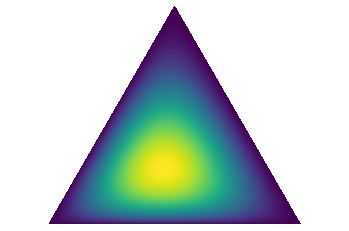

tensor([0.4348, 0.2538, 0.3113], grad_fn=<DivBackward0>)
tensor([2.5298, 1.4565, 1.9365], grad_fn=<AddBackward0>)


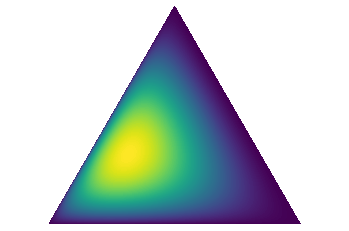

In [173]:
for point in [TEST_POINT1, TEST_POINT2, TEST_POINT3]:
    preds_priornet = classification_priornet.get_predictions(torch.FloatTensor(point))
    print(preds_priornet)
    alphas_priornet = classification_priornet.get_alphas(torch.FloatTensor(point))
    print(alphas_priornet)
    draw_pdf_contours(alphas_priornet.detach().numpy())

## Regression example

For the regression example, we generate the data ourselves. We do this by defining a function and a noise term.

In [ ]:
def generate_data(num_points: int, seed: int = 1234):
    np.random.seed(seed)
    x = np.arange(0, 10, 10 / num_points)
    
    func = lambda x: np.sin(x) + 0.3 * x + 0.1
    noise = np.random.randn(*x.shape)
    
    return x, func(x), func(x) + noise / 4

In [ ]:
# Plot the data!

plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
plt.grid(visible=True)
x, true_y, y = generate_data(num_points=100)

plt.plot(x, true_y, alpha=0.6, color="red", label="True function", linewidth=4)
plt.scatter(x, y, alpha=0.6, color="blue", label="Observations", s=55)

ax.set_xlabel("x", fontsize = 16)
ax.set_ylabel('y', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
plt.show()